# Notebook for building cages from Andrew Marsh precursors

Distributed under the terms of the MIT License.

Author: Andrew Tarzia

Date Created: 22 Feb 2019


In [201]:
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG = True
import glob
import stk
import pywindow as pw
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from ase.visualize import view
import copy
from ase.io import read

In [133]:
precursor_dir = '/home/atarzia/projects/andrew_marsh_structures/precursor_lib/'
output_dir = '/home/atarzia/projects/andrew_marsh_structures/output/'
macromod_ = '/home/atarzia/software/schrodinger_install'
# '/rds/general/user/fszczypi/home/schrodinger2018-4'
big_DB = '/data/atarzia/precursor_DBs/reaxys_sorted/'
aldehydes2f = big_DB+'aldehydes2f/'
print(len(glob.glob(aldehydes2f+'*mol')), 'precusrors in', aldehydes2f)
aldehydes3f = big_DB+'aldehydes3f/'
print(len(glob.glob(aldehydes3f+'*mol')), 'precusrors in', aldehydes3f)
amines2f = big_DB+'amines2f/'
print(len(glob.glob(amines2f+'*mol')), 'precusrors in', amines2f)
amines3f = big_DB+'amines3f/'
print(len(glob.glob(amines3f+'*mol')), 'precusrors in', amines3f)

280 precusrors in /data/atarzia/precursor_DBs/reaxys_sorted/aldehydes2f/
63 precusrors in /data/atarzia/precursor_DBs/reaxys_sorted/aldehydes3f/
507 precusrors in /data/atarzia/precursor_DBs/reaxys_sorted/amines2f/
90 precusrors in /data/atarzia/precursor_DBs/reaxys_sorted/amines3f/


In [134]:
# synthetic accessibility DBs
amines2f_SA = pd.read_csv(amines2f+'score_output_amines2f.csv')
amines3f_SA = pd.read_csv(amines3f+'score_output_amines3f.csv')

In [4]:
precursor_files = sorted(glob.glob(precursor_dir+'*.mol'))
precursor_names = [i.replace(precursor_dir, '') for i in precursor_files]
precursor_struc = [stk.StructUnit3(i) for i in precursor_files]  # read in mol files

## Aldehyde 1

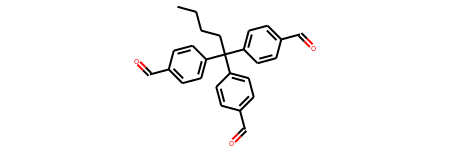

In [5]:
Chem.MolFromInchi(precursor_struc[0].inchi)

## Aldehyde 2

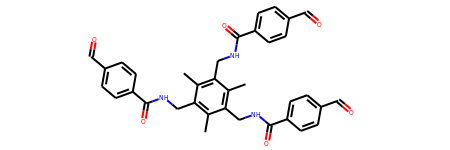

In [6]:
Chem.MolFromInchi(precursor_struc[1].inchi)

## Aldehyde 3

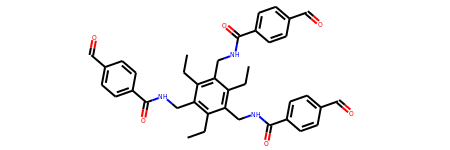

In [7]:
Chem.MolFromInchi(precursor_struc[2].inchi)

## Aldehyde 4

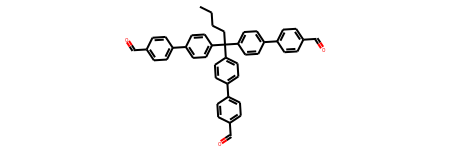

In [8]:
Chem.MolFromInchi(precursor_struc[3].inchi)

# Brute force production of cages
- for all 4 precursors
- all possible topologies (3aldehdye+2amine)
- all possible topologies (3aldehdye+3amine)
- macromodel optimization will determine if collapsed
- run full pywindow analysis
    - output properties
- read pywindow results
    - produce CSV: BB-aldehyde, BB-amine, collapsed?, ....

In [38]:
def expected_window(topo):
    e_wind = {'dodec': 12, '4p6': 4, '4p62': 4,
          '8p12': 6,  '6p9': 5, '2p3': 3, 
          '4p4': 6, '1p1': 3, '2p2': 4}
    return e_wind[topo]

def is_collapse(topo, avg_diff, max_window_diam, cavity_size, no_window):
    expected_wind = expected_window(topo)
    if expected_wind == no_window:
        alpha = 4 * avg_diff / (max_window_diam * expected_wind)
        if alpha < 0.035 and cavity_size > 1:
            # not collapsed
            return False
        else:
            # unknown
            return None
    else:
        # collapsed
        return True
    

def get_assymmetry(data):
    """Calculate assymetry as defined in GA paper (Berardo)
    
    The sum of all the windows' pair differences represents the asymmetry of the individual, Asymmetry parameter in eqn (1)
    """
    window_sizes = data['windows']['diameters']
    total = 0
    for i, a in enumerate(window_sizes):
        for j, b in enumerate(window_sizes[i:]):
            if i != j+i:
#                 print(i, j, j+i)
#                 print(a, b)
                diff = abs(a - b)
                total += diff
    return total   

In [39]:
from stk.molecular.molecules import MacroMoleculeBuildError

In [11]:
# prepare output file
output_csv = 'full_output_amines3f.csv'
if input('wipe??') == 't':
    with open(output_dir+output_csv, 'w') as f:
        f.write('name,bb1,SA1,bb2,SA2,topo,max_diam,p_diam,p_vol,p_diam_opt,p_vol_opt,w_no,w_max,w_min,w_avg,w_diff,collapse,assym\n')

wipe??


In [12]:
# triamines (alde3+amine3)
topology_names = ['1p1', '4p4']  # , '2p2']
topology_options = [stk.three_plus_three.OnePlusOne(bb_positions={0: [0], 1: [1]}), # place bb1 on vertex (0), bb2 on vertex (1)
                    stk.three_plus_three.FourPlusFour(bb_positions={0: [0, 3, 5, 6], 1: [1, 2, 4, 7]})] # , # place bb1 on vertex (0, 2), bb2 on vertex (1, 3)
                    # stk.three_plus_three.TwoPlusTwo(bb_positions={0: [0, 2], 1: [1, 3]})] # place bb1 on vertex (0, 2), bb2 on vertex (1, 3)
DB = amines3f
amines = glob.glob(DB+'*.mol')

for i, prec in enumerate(precursor_struc):
    print('doing:', precursor_files[i])
    for j, amine in enumerate(amines):
        bb_amine = stk.StructUnit3(amine)
        for k, topo in enumerate(topology_options):
            # naming convention: aldehyde-name_amine-name_topology
            # amine-name: amineDB_NO
            NAME = precursor_names[i].replace('.mol', '')
            NAME += '_'+amine.replace('.mol', '').replace(DB, '')+'_'
            NAME += topology_names[k]
            prop_file = output_dir+NAME+'_opt_properties.json'
            mole_file = output_dir+NAME+'_opt_PWout.xyz'
            if os.path.isfile(output_dir+NAME+'_opt.mol') is False:
#                 print(NAME)
                try:
                    cage = stk.Cage([prec, bb_amine], topo)
                    cage.write(output_dir+NAME+'.mol')
                    stk.macromodel_opt(cage, macromodel_path=macromod_, 
                                       settings={'restricted': False,
                                                 'timeout': None,
                                                 'force_field': 16,
                                                 'max_iter': 2500,
                                                 'gradient': 0.05,
                                                 'md': True
                                                },
                                       md={'timeout': None,
                                           'force_field': 16,
                                           'temp': 700,
                                           'confs': 50,
                                           'time_step': 1.0,
                                           'eq_time': 10,
                                           'sim_time': 200,
                                           'max_iter': 2500,
                                           'gradient': 0.05
                                          })
                    cage.write(output_dir+NAME+'_opt.mol')
                    # check if completed
                    if os.path.isfile(prop_file) is False:
                        # Import optimised cage into pyWindow, via RDkit mol file
                        cage_rd = Chem.MolFromMolFile(output_dir+NAME+'_opt.mol')
                        cage_sys = pw.MolecularSystem.load_rdkit_mol(cage_rd)
                        cage_mol = cage_sys.system_to_molecule()
                        # Perform full pyWindow analysis
                        cage_mol.full_analysis()
                        # Dump pyWindow properties into JSON and cage into xyz
                        cage_mol.dump_properties_json(prop_file)
                        cage_mol.dump_molecule(mole_file, include_coms=True)    
                except MacroMoleculeBuildError:
                    pass
                if os.path.isfile(prop_file) is True:
                    # all analysis done successfully -- output
                    bb1, SA1, bb2, SA2, topo = '-', '-', '-', '-', '-'
                    max_diam, p_diam, p_vol = '-', '-', '-'
                    p_diam_opt, p_vol_opt = '-', '-'
                    w_no, w_max, w_min, w_avg = '-', '-', '-', '-'
                    w_diff, collapsed, assymetry = '-', '-', '-'
                    with open(prop_file, 'r') as f:
                        data = json.load(f)
                    bb1 = NAME.split('_')[0]
                    bb2 = '_'.join(NAME.split('_')[1:3])
                    topo = NAME.split('_')[3]
                    max_diam = str(data['maximum_diameter']['diameter'])
                    p_diam = str(data['pore_diameter']['diameter'])
                    p_diam_opt = str(data['pore_diameter_opt']['diameter'])
                    p_vol = str(data['pore_volume'])
                    p_vol_opt = str(data['pore_volume_opt'])
                    if data['windows']['diameters'] is None:
                        w_no, w_max, w_min, w_avg, w_diff = '0', '0', '0', '0', '0'
                        collapse = '2'  # unsure
                        assymetry = '-2'
                    elif len(data['windows']['diameters']) == 0:
                        w_no, w_max, w_min, w_avg, w_diff = '0', '0', '0', '0', '0'
                        collapse = '1'  # collapsed
                        assymetry = '-2'
                    else:
                        if max(data['windows']['diameters']) < 200:
                            w_no = str(len(data['windows']['diameters']))
                            w_max = str(max(data['windows']['diameters']))
                            w_min = str(min(data['windows']['diameters']))
                            w_avg = str(np.average(data['windows']['diameters']))
                            w_diff = str(cage.window_difference())
                            if w_diff is None:
                                w_diff = '-5'
                            assymetry = str(get_assymmetry(data))
                            coll_flag = is_collapse(topo=topo, avg_diff=w_diff, max_window_diam=w_max, 
                                                    cavity_size=cage.cavity_size(), no_window=w_no)
                            if coll_flag is True:
                                collapse = '0'
                            elif coll_flag is False:
                                collapse = '1'
                            elif coll_flag is None:
                                collapse = '2'
                        else:
                            w_no, w_max, w_min, w_avg, w_diff = '-1', '-1', '-1', '-1', '-1'
                            collapse = '2'  # unsure
                            assymetry = '-1'
                    with open(output_dir+output_csv, 'a') as f:
                        f.write(NAME+','+bb1+','+SA1+','+bb2+','+SA2+','+topo+',')
                        f.write(max_diam+','+p_diam+','+p_vol+','+p_diam_opt+',')
                        f.write(p_vol_opt+','+w_no+','+w_max+','+w_min+','+w_avg+',')
                        f.write(w_diff+','+collapse+','+assymetry)
                        f.write('\n')

doing: /home/atarzia/projects/andrew_marsh_structures/precursor_lib/aldehyde1.mol
doing: /home/atarzia/projects/andrew_marsh_structures/precursor_lib/aldehyde2.mol
doing: /home/atarzia/projects/andrew_marsh_structures/precursor_lib/aldehyde3.mol
doing: /home/atarzia/projects/andrew_marsh_structures/precursor_lib/aldehyde4.mol


In [13]:
# Check that the number output files matches the expected number based on inputs
print(len(glob.glob(precursor_dir+'*mol')), 'precusrors in', precursor_dir)
print(len(glob.glob(amines3f+'*mol')), 'precusrors in', amines3f)
print(len(topology_options), 'possible topologies per cage')
n_cages = len(glob.glob(precursor_dir+'*mol')) * len(glob.glob(amines3f+'*mol')) * len(topology_options)
print('>>', n_cages, 'cages')
print(len(glob.glob(output_dir+'*amine3f*_opt*mol')), 'cages optimized')

4 precusrors in /home/atarzia/projects/andrew_marsh_structures/precursor_lib/
90 precusrors in /data/atarzia/precursor_DBs/reaxys_sorted/amines3f/
2 possible topologies per cage
>> 720 cages
720 cages optimized


In [14]:
# Check that the number output files matches the expected number based on inputs
opt_cages = len(glob.glob(output_dir+'*_opt*mol'))
print('>>', opt_cages, 'cages')
print(len(glob.glob(output_dir+'*_properties.json')), 'cage properties calculated')
print(len(glob.glob(output_dir+'*_PWout.xyz')), 'cage window structures output')

>> 4531 cages
4531 cage properties calculated
4531 cage window structures output


# Analysis

In [175]:
topo_markers = {'1p1': 'o', '4p4': '<', '2p3': 'X', '4p6': 'D', '4p62': 'P', '6p9': '>'}
topo_lab = {'1p1': '1+1', '4p4': '4+4', '2p3': '2+3', '4p6': '4+6', '4+6 - 2': 'P', '6p9': '6+9'}
ald_colo = {'aldehyde1': 'k', 'aldehyde2': 'b', 'aldehyde3': 'r', 'aldehyde4': 'g'}
des_topo = ['1p1', '4p4']

### Read in results

In [176]:
full_dataset = pd.read_csv(output_dir+output_csv)
print(full_dataset.columns)

Index(['name', 'bb1', 'SA1', 'bb2', 'SA2', 'topo', 'max_diam', 'p_diam',
       'p_vol', 'p_diam_opt', 'p_vol_opt', 'w_no', 'w_max', 'w_min', 'w_avg',
       'w_diff', 'collapse', 'assym'],
      dtype='object')


#### Visualisation if you want

In [21]:
for i, row in full_dataset[full_dataset.topo == '4p4'].iterrows():
    print(row)
    print(row.bb1, row.bb2, row.SA2)
    NAME = row.bb1+'_'+row.bb2+'_'+row.topo
    prop_file = output_dir+NAME+'_opt_properties.json'
    with open(prop_file, 'r') as f:
        data = json.load(f)
    asymmetry = get_assymmetry(data)
    print(asymmetry)
    view(read(output_dir+row.bb1+'_'+row.bb2+'_'+row.topo+'_opt_PWout.xyz'))
    input()
    clear_output()

name          aldehyde1_amine3f_101_4p4
bb1                           aldehyde1
SA1                                   -
bb2                         amine3f_101
SA2                                   -
topo                                4p4
max_diam                        26.0653
p_diam                          8.12795
p_vol                           281.152
p_diam_opt                      8.20949
p_vol_opt                       289.699
w_no                                  6
w_max                           5.83042
w_min                           4.31257
w_avg                           4.98527
w_diff               0.8619243110090797
collapse                              0
assym                           10.9517
Name: 3, dtype: object
aldehyde1 amine3f_101 -
10.951705216243957


KeyboardInterrupt: 

## Determine the energy of all optimized cages and all building blocks to determine formation energy of cages

Use OPLS3 in macromodel

In [202]:
working_dataset = copy.deepcopy(full_dataset)

### aldehyde precurors

In [203]:
prec_ey_file = precursor_dir+'all_prec_ey.json'
cage_ey_file = output_dir+'all_cage_ey.json'

In [204]:
with open(prec_ey_file, 'r') as f:
    calculated = json.load(f)
energies = {}
for file in precursor_files:
    print(file)
    NAME = file.replace(precursor_dir, '').replace('.mol', '')
    opt_out = file.replace('.mol', '_opt.mol')
    struct = stk.StructUnit(file)
#     struct.energy.macromodel(16, macromod_)
#     print(struct.energy.values)
    # optimize
    if NAME not in calculated:
        stk.macromodel_opt(struct, 
                           macromodel_path=macromod_, 
                           settings={'restricted': False,
                                     'timeout': None,
                                     'force_field': 16,
                                     'max_iter': 2500,
                                     'gradient': 0.05,
                                     'md': True},
                           md={'timeout': None,
                               'force_field': 16,
                               'temp': 700,
                               'confs': 50,
                               'time_step': 1.0,
                               'eq_time': 10,
                               'sim_time': 200,
                               'max_iter': 2500,
                               'gradient': 0.05})
        # get energy
        struct.energy.macromodel(16, macromod_)
        for i in struct.energy.values:
            energies[NAME] = struct.energy.values[i]
            calculated[NAME] = struct.energy.values[i]
    else:
        energies[NAME] = calculated[NAME]

/home/atarzia/projects/andrew_marsh_structures/precursor_lib/aldehyde1.mol
/home/atarzia/projects/andrew_marsh_structures/precursor_lib/aldehyde2.mol
/home/atarzia/projects/andrew_marsh_structures/precursor_lib/aldehyde3.mol
/home/atarzia/projects/andrew_marsh_structures/precursor_lib/aldehyde4.mol


In [205]:
bb1_energies = []
for i, row in working_dataset.iterrows():
    bb1_energies.append(energies[row.bb1])

working_dataset['bb1_ey'] = bb1_energies

In [206]:
# save energies of calculated precursors to avoid recalculation
with open(prec_ey_file, 'w') as f:
    json.dump(calculated, f)

(array([1., 0., 0., 1., 0., 0., 1., 0., 0., 1.]),
 array([ 29.344  ,  63.31348,  97.28296, 131.25244, 165.22192, 199.1914 ,
        233.16088, 267.13036, 301.09984, 335.06932, 369.0388 ]),
 <a list of 10 Patch objects>)

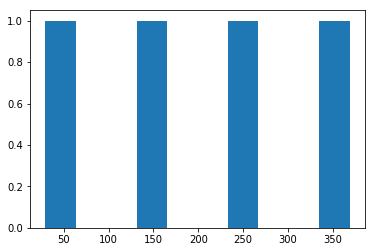

In [207]:
plt.hist(list(set(working_dataset.bb1_ey)))

### amine 3 precursors

In [208]:
with open(prec_ey_file, 'r') as f:
    calculated = json.load(f)
energies = {}
for file in glob.glob(amines3f+'*mol'):
#     print(file)
    NAME = file.replace(amines3f, '').replace('.mol', '')
#     print(NAME)
    struct = stk.StructUnit(file)
#     struct.energy.macromodel(16, macromod_)
#     print(struct.energy.values)
    # optimize
#     if NAME not in list(final_db.bb2):
#         continue
    if NAME not in calculated:
        stk.macromodel_opt(struct, 
                           macromodel_path=macromod_, 
                           settings={'restricted': False,
                                     'timeout': None,
                                     'force_field': 16,
                                     'max_iter': 2500,
                                     'gradient': 0.05,
                                     'md': True},
                           md={'timeout': None,
                               'force_field': 16,
                               'temp': 700,
                               'confs': 50,
                               'time_step': 1.0,
                               'eq_time': 10,
                               'sim_time': 200,
                               'max_iter': 2500,
                               'gradient': 0.05})
        # get energy
        struct.energy.macromodel(16, macromod_)
        for i in struct.energy.values:
            energies[NAME] = struct.energy.values[i]
            calculated[NAME] = struct.energy.values[i]
    else:
        energies[NAME] = calculated[NAME]

In [215]:
# save energies of calculated precursors to avoid recalculation
with open(prec_ey_file, 'w') as f:
    json.dump(calculated, f)

In [216]:
bb2_energies = []
for i, row in working_dataset.iterrows():
    bb2_energies.append(energies[row.bb2])

working_dataset['bb2_ey'] = bb2_energies

(array([  8.,   0.,   8.,  48., 120., 184., 216., 112.,   8.,  16.]),
 array([-683.5192 , -532.92594, -382.33268, -231.73942,  -81.14616,
          69.4471 ,  220.04036,  370.63362,  521.22688,  671.82014,
         822.4134 ]),
 <a list of 10 Patch objects>)

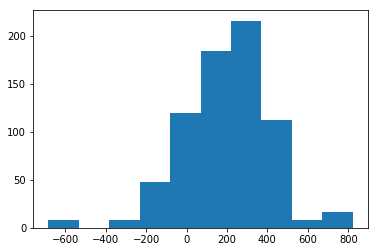

In [217]:
plt.hist(working_dataset.bb2_ey)

### amine 2 precursors

In [218]:
with open(prec_ey_file, 'r') as f:
    calculated = json.load(f)
energies = {}
for file in glob.glob(amines2f+'*mol'):
#     print(file)
    NAME = file.replace(amines2f, '').replace('.mol', '')
#     print(NAME)
    struct = stk.StructUnit(file)
#     struct.energy.macromodel(16, macromod_)
#     print(struct.energy.values)
    # optimize
#     if NAME not in list(final_db.bb2):
#         continue
    if NAME not in calculated:
        stk.macromodel_opt(struct, 
                           macromodel_path=macromod_, 
                           settings={'restricted': False,
                                     'timeout': None,
                                     'force_field': 16,
                                     'max_iter': 2500,
                                     'gradient': 0.05,
                                     'md': True},
                           md={'timeout': None,
                               'force_field': 16,
                               'temp': 700,
                               'confs': 50,
                               'time_step': 1.0,
                               'eq_time': 10,
                               'sim_time': 200,
                               'max_iter': 2500,
                               'gradient': 0.05})
        # get energy
        struct.energy.macromodel(16, macromod_)
        for i in struct.energy.values:
            energies[NAME] = struct.energy.values[i]
            calculated[NAME] = struct.energy.values[i]
    else:
        energies[NAME] = calculated[NAME]

In [219]:
# save energies of calculated precursors to avoid recalculation
with open(prec_ey_file, 'w') as f:
    json.dump(calculated, f)

In [220]:
bb2_energies = []
for i, row in working_dataset.iterrows():
    bb2_energies.append(calculated[row.bb2])

working_dataset['bb2_ey'] = bb2_energies

(array([  8.,   0.,   8.,  48., 120., 184., 216., 112.,   8.,  16.]),
 array([-683.5192 , -532.92594, -382.33268, -231.73942,  -81.14616,
          69.4471 ,  220.04036,  370.63362,  521.22688,  671.82014,
         822.4134 ]),
 <a list of 10 Patch objects>)

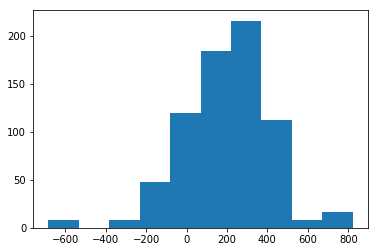

In [221]:
plt.hist(working_dataset.bb2_ey)

### cages

In [222]:
with open(cage_ey_file, 'r') as f:
    cage_calculated = json.load(f)

In [223]:
energies = []
count = 0
cage_calculated = {}
for i, row in working_dataset.iterrows():
    NAME = row.bb1+'_'+row.bb2+'_'+row.topo
    cage_file = output_dir+NAME+'_opt.mol'
    if NAME not in cage_calculated:
        new_cage = stk.StructUnit(cage_file)
        new_cage.energy.macromodel(16, macromod_)
        for i in new_cage.energy.values:
            energies.append(new_cage.energy.values[i])
            cage_calculated[NAME] = new_cage.energy.values[i]
        count += 1
    else:
        energies.append(cage_calculated[NAME])
working_dataset['cage_ey'] = energies

In [224]:
# save energies of calculated cages to avoid recalculation
with open(cage_ey_file, 'w') as f:
    json.dump(cage_calculated, f)

(array([ 70., 120., 174.,  74.,  61.,  71.,  74.,  28.,  31.,  17.]),
 array([-197.2703 ,  233.66181,  664.59392, 1095.52603, 1526.45814,
        1957.39025, 2388.32236, 2819.25447, 3250.18658, 3681.11869,
        4112.0508 ]),
 <a list of 10 Patch objects>)

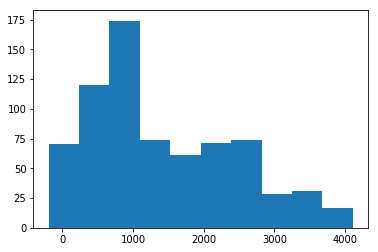

In [225]:
plt.hist(working_dataset.cage_ey)

## Calculate formation energies

### Need energy of water (1 per imine bond formed)

In [226]:
h2o = Chem.AddHs(Chem.MolFromSmiles('O'))
Chem.MolToMolFile(h2o, output_dir+'h2o.mol')

In [227]:
struct = stk.StructUnit(output_dir+'h2o.mol')
stk.macromodel_opt(struct, 
                   macromodel_path=macromod_, 
                   settings={'restricted': False,
                             'timeout': None,
                             'force_field': 16,
                             'max_iter': 2500,
                             'gradient': 0.05,
                             'md': True},
                   md={'timeout': None,
                       'force_field': 16,
                       'temp': 700,
                       'confs': 50,
                       'time_step': 1.0,
                       'eq_time': 10,
                       'sim_time': 200,
                       'max_iter': 2500,
                       'gradient': 0.05})
# get energy
struct.energy.macromodel(16, macromod_)
for i in struct.energy.values:
    H2O_energy = struct.energy.values[i]

In [228]:
H2O_energy

0.0

In [229]:
form_energies = []
stoich = {'1p1': {'bb1': 1, 'bb2': 1, 'h2o': 3},
          '4p4': {'bb1': 4, 'bb2': 4, 'h2o': 12},
          '2p3': {'bb1': 2, 'bb2': 3, 'h2o': 6},
          '4p6': {'bb1': 4, 'bb2': 6, 'h2o': 12},
          '4p62': {'bb1': 4, 'bb2': 6, 'h2o': 12},
          '6p9': {'bb1': 6, 'bb2': 9, 'h2o': 18}}
for i, row in working_dataset.iterrows():
    FE = (row.cage_ey + stoich[row.topo]['h2o'] * H2O_energy) - (row.bb1_ey * stoich[row.topo]['bb1'] + row.bb2_ey * stoich[row.topo]['bb2'])
    form_energies.append(FE)

working_dataset['form_ey'] = form_energies

In [230]:
working_dataset[abs(working_dataset.form_ey) > 500]

,name,bb1,SA1,bb2,SA2,topo,max_diam,p_diam,p_vol,p_diam_opt,...,w_max,w_min,w_avg,w_diff,collapse,assym,bb1_ey,bb2_ey,cage_ey,form_ey
1,aldehyde1_amine3f_236_4p4,aldehyde1,-,amine3f_236,-,4p4,30.685763,2.869327,12.369113,5.569277,...,6.404091,1.243043,5.038282,None,0,15.567608,263.8998,386.7437,3238.7947,636.2207
2,aldehyde1_amine3f_101_1p1,aldehyde1,-,amine3f_101,-,1p1,15.915195,-2.003377,-4.210044,-2.003377,...,0.000000,0.000000,0.000000,0,2,-2.000000,263.8998,313.7573,1346.3533,768.6962
4,aldehyde1_amine3f_266_1p1,aldehyde1,-,amine3f_266,-,1p1,16.747831,-2.202187,-5.591927,-2.202187,...,0.000000,0.000000,0.000000,0,2,-2.000000,263.8998,-3.4182,886.9500,626.4684
5,aldehyde1_amine3f_266_4p4,aldehyde1,-,amine3f_266,-,4p4,25.754883,5.789355,101.598963,6.038343,...,3.745062,2.696380,3.326872,0.4281595707084486,0,6.826802,263.8998,-3.4182,1593.0137,551.0873
8,aldehyde1_amine3f_16_1p1,aldehyde1,-,amine3f_16,-,1p1,15.303503,-2.370596,-6.975439,-2.370596,...,0.000000,0.000000,0.000000,0,2,-2.000000,263.8998,-26.6105,849.8538,612.5645
10,aldehyde1_amine3f_103_1p1,aldehyde1,-,amine3f_103,-,1p1,15.557483,1.708704,2.612156,1.803623,...,1.033738,0.952363,0.982650,None,0,0.162750,263.8998,-173.5306,1012.7723,922.4031
11,aldehyde1_amine3f_103_4p4,aldehyde1,-,amine3f_103,-,4p4,25.600457,6.109853,119.423808,6.817970,...,6.142817,2.429779,3.682944,2.5716602995839355,0,28.978491,263.8998,-173.5306,2439.8782,2078.4014
12,aldehyde1_amine3f_206_1p1,aldehyde1,-,amine3f_206,-,1p1,15.616220,1.569550,2.024531,1.873062,...,1.048942,1.029677,1.039048,None,0,0.038530,263.8998,73.7150,1217.1533,879.5385
13,aldehyde1_amine3f_206_4p4,aldehyde1,-,amine3f_206,-,4p4,26.304883,7.338622,206.938916,7.502391,...,5.724051,4.322302,4.949336,0.7766354184917567,0,9.324326,263.8998,73.7150,3389.8306,2039.3714
16,aldehyde1_amine3f_182_1p1,aldehyde1,-,amine3f_182,-,1p1,16.721972,-1.584515,-2.082994,-1.584515,...,0.000000,0.000000,0.000000,0,2,-2.000000,263.8998,375.9257,1182.7037,542.8782


(array([  8.,   0.,   7., 122., 300., 229.,  21.,  11.,  18.,   4.]),
 array([-2.02236010e+03, -1.51661984e+03, -1.01087958e+03, -5.05139320e+02,
         6.00940000e-01,  5.06341200e+02,  1.01208146e+03,  1.51782172e+03,
         2.02356198e+03,  2.52930224e+03,  3.03504250e+03]),
 <a list of 10 Patch objects>)

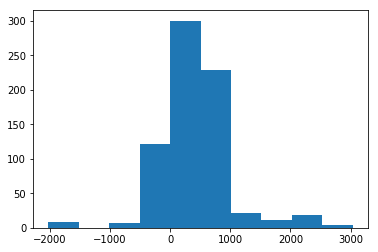

In [231]:
plt.hist(working_dataset.form_ey)

### calculate the most stable (by formation energy) of each topology for a pair of BB
- add column to final DB of relative form energy (0 if most stable topo)

In [233]:
energies = []
# iterate through and collect amine buidling blocks that produce cages with reasonable properties
count = 0
for i, row in working_dataset.iterrows():
#     print(row)
    new_db = working_dataset[working_dataset.bb1 == row.bb1]
    new_db = new_db[new_db.bb2 == row.bb2]
#     print(new_db)
    FEs = sorted(list(new_db.form_ey))
#     print(FEs)
    energies.append(row.form_ey - min(FEs))
#     print(energies)
#     break
working_dataset['rel_form_ey'] = energies

## Screening cages

In [348]:
amines = []
cages = []
final_db = pd.DataFrame(columns=working_dataset.columns)
# iterate through and collect amine buidling blocks that produce cages with reasonable properties
for i, row in working_dataset.iterrows():
    if row.topo not in des_topo:
        continue
    # remove those with pore diamter < 3.4 angstrom 
    # (Computationally-inspired discovery of an unsymmetrical porous organic cage)
    if row.p_diam_opt < 3.4:
        continue
    # remove those that have no windows
    if row.assym == -2:
        continue
    # remove those with max window diamter < 2.8 angstrom 
    # (Computationally-inspired discovery of an unsymmetrical porous organic cage)
    if row.p_diam_opt < 2.8:
        continue
    # recalculate assymetry - remove cases with assymetry > 1
    NAME = row.bb1+'_'+row.bb2+'_'+row.topo
    prop_file = output_dir+NAME+'_opt_properties.json'
    with open(prop_file, 'r') as f:
        data = json.load(f)
    asymmetry = get_assymmetry(data)
    row.assym = asymmetry
    # remove structures with no. windows < expected for topology
    if row.w_no < expected_window(row.topo):
        continue
    # get synthetic accessibility of amines
    if 'amine2f' in row.bb2:
        row.SA2 = float(amines2f_SA[amines2f_SA['name'] == row.bb2].SC)
    elif 'amine3f' in row.bb2:
        row.SA2 = float(amines3f_SA[amines3f_SA['name'] == row.bb2].SC)
    amines.append(row.bb2)
    cages.append(row['name'])
    final_db = final_db.append(row)
print(len(final_db))

208


In [349]:
final_db[final_db.w_max > 3.5]

,name,bb1,SA1,bb2,SA2,topo,max_diam,p_diam,p_vol,p_diam_opt,...,w_min,w_avg,w_diff,collapse,assym,bb1_ey,bb2_ey,cage_ey,form_ey,rel_form_ey
3,aldehyde1_amine3f_101_4p4,aldehyde1,-,amine3f_101,1.853383,4p4,26.065286,8.127946,281.151868,8.209486,...,4.312572,4.985271,0.8619243110090797,0,10.951705,263.8998,313.7573,2774.5701,463.9417,0.0000
5,aldehyde1_amine3f_266_4p4,aldehyde1,-,amine3f_266,2.531822,4p4,25.754883,5.789355,101.598963,6.038343,...,2.696380,3.326872,0.4281595707084486,0,6.826802,263.8998,-3.4182,1593.0137,551.0873,0.0000
9,aldehyde1_amine3f_16_4p4,aldehyde1,-,amine3f_16,1.825457,4p4,23.994701,5.444788,84.516498,5.831082,...,2.019156,2.565694,0.8502082555204742,0,10.110147,263.8998,-26.6105,1327.0083,377.8511,0.0000
11,aldehyde1_amine3f_103_4p4,aldehyde1,-,amine3f_103,2.373253,4p4,25.600457,6.109853,119.423808,6.817970,...,2.429779,3.682944,2.5716602995839355,0,28.978491,263.8998,-173.5306,2439.8782,2078.4014,1155.9983
13,aldehyde1_amine3f_206_4p4,aldehyde1,-,amine3f_206,2.448908,4p4,26.304883,7.338622,206.938916,7.502391,...,4.322302,4.949336,0.7766354184917567,0,9.324326,263.8998,73.7150,3389.8306,2039.3714,1159.8329
17,aldehyde1_amine3f_182_4p4,aldehyde1,-,amine3f_182,2.329526,4p4,26.235833,5.413765,83.080042,5.925267,...,2.508319,3.124005,0.48387477005259283,0,9.041918,263.8998,375.9257,2761.0017,201.6997,0.0000
19,aldehyde1_amine3f_258_4p4,aldehyde1,-,amine3f_258,2.538301,4p4,26.347957,6.076144,117.458077,7.039807,...,3.560759,5.370759,1.298496760055879,0,14.150203,263.8998,221.6619,2393.4275,451.1807,0.0000
23,aldehyde1_amine3f_37_4p4,aldehyde1,-,amine3f_37,1.760528,4p4,25.645442,8.089397,277.170542,8.831729,...,4.720096,5.422243,0.4068683856072487,0,5.964191,263.8998,123.8902,2147.5669,596.4069,103.7065
25,aldehyde1_amine3f_241_4p4,aldehyde1,-,amine3f_241,2.987953,4p4,30.942343,5.172187,72.447136,7.446131,...,3.087487,4.540361,1.5534290746815278,0,25.364009,263.8998,290.2632,2781.6465,564.9945,207.4064
27,aldehyde1_amine3f_152_4p4,aldehyde1,-,amine3f_152,3.330344,4p4,31.137395,4.620956,51.664725,7.536845,...,4.163884,6.009834,2.1825535672313037,0,27.753548,263.8998,278.3115,2758.9680,590.1228,366.1078


#### Visulisation if you want

In [44]:
for i, row in final_db[final_db.w_max > 3.5].iterrows():
    print(row.bb2, row.SA2)
    view(read(output_dir+row.bb1+'_'+row.bb2+'_'+row.topo+'_opt_PWout.xyz'))
    input()

amine3f_101 1.853382750403991

amine3f_266 2.531822482417298

amine3f_16 1.825456921830836
ii
amine3f_103 2.373252906381248


KeyboardInterrupt: 

## Plotting

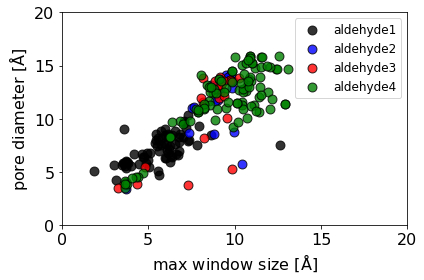

In [350]:
fig, ax = plt.subplots()
for i in ald_colo:
    data = final_db[final_db.bb1 == i]
    ax.scatter(data.w_max, data.p_diam_opt, c=ald_colo[i], alpha=0.8, 
               edgecolor='k', marker='o', s=80, label=i)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_xlabel('max window size [$\mathrm{\AA}$]', fontsize=16)
ax.set_ylabel('pore diameter [$\mathrm{\AA}$]', fontsize=16)
ax.set_xlim(0, 20)
ax.set_ylim(0, 20)

ax.legend(fontsize=12)
fig.tight_layout()
fig.savefig(output_dir+"pdiam_VS_wmax_3f.pdf",
            dpi=720, bbox_inches='tight')

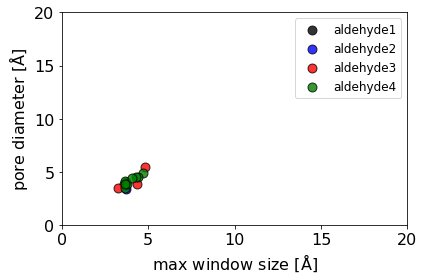

In [351]:
temp_db = final_db[final_db.topo == '1p1']
fig, ax = plt.subplots()
for i in ald_colo:
    data = temp_db[temp_db.bb1 == i]
    ax.scatter(data.w_max, data.p_diam_opt, c=ald_colo[i], alpha=0.8, 
               edgecolor='k', marker='o', s=80, label=i)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_xlabel('max window size [$\mathrm{\AA}$]', fontsize=16)
ax.set_ylabel('pore diameter [$\mathrm{\AA}$]', fontsize=16)
ax.set_xlim(0, 20)
ax.set_ylim(0, 20)

ax.legend(fontsize=12)
fig.tight_layout()
fig.savefig(output_dir+"pdiam_VS_wmax_3f_1p1.pdf",
            dpi=720, bbox_inches='tight')

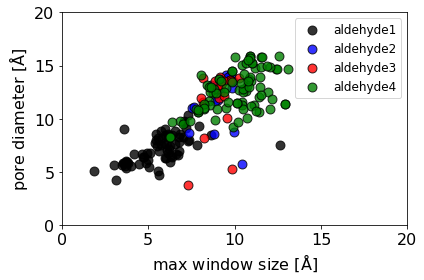

In [352]:
temp_db = final_db[final_db.topo == '4p4']
fig, ax = plt.subplots()
for i in ald_colo:
    data = temp_db[temp_db.bb1 == i]
    ax.scatter(data.w_max, data.p_diam_opt, c=ald_colo[i], alpha=0.8, 
               edgecolor='k', marker='o', s=80, label=i)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_xlabel('max window size [$\mathrm{\AA}$]', fontsize=16)
ax.set_ylabel('pore diameter [$\mathrm{\AA}$]', fontsize=16)
ax.set_xlim(0, 20)
ax.set_ylim(0, 20)

ax.legend(fontsize=12)
fig.tight_layout()
fig.savefig(output_dir+"pdiam_VS_wmax_3f_4p4.pdf",
            dpi=720, bbox_inches='tight')

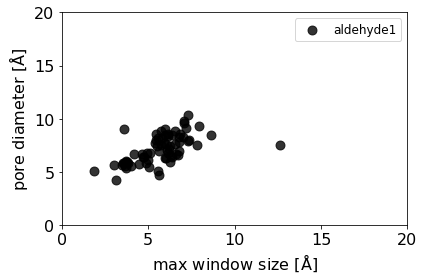

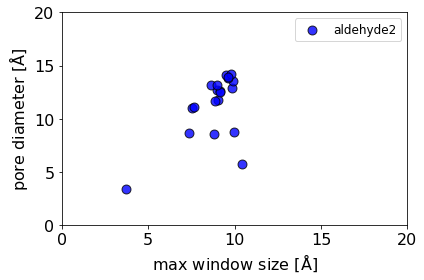

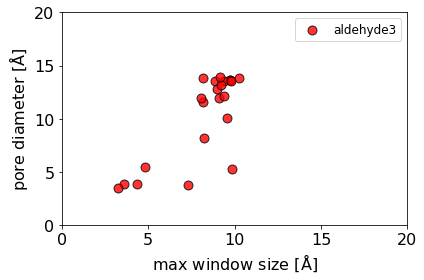

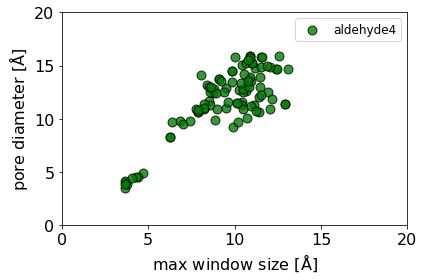

In [353]:
for i in ald_colo:
    fig, ax = plt.subplots()
    data = final_db[final_db.bb1 == i]
    ax.scatter(data.w_max, data.p_diam_opt, c=ald_colo[i], alpha=0.8, 
               edgecolor='k', marker='o', s=80, label=i)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.set_xlabel('max window size [$\mathrm{\AA}$]', fontsize=16)
    ax.set_ylabel('pore diameter [$\mathrm{\AA}$]', fontsize=16)
    ax.set_xlim(0, 20)
    ax.set_ylim(0, 20)

    ax.legend(fontsize=12)
    fig.tight_layout()
    fig.savefig(output_dir+"pdiam_VS_wmax_3f_"+i+".pdf",
                dpi=720, bbox_inches='tight')

## From here on, just plot for 4+4

In [354]:
final_2_db = final_db[final_db.topo == '4p4']

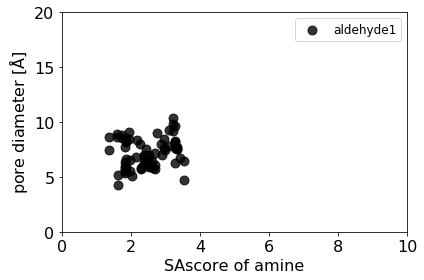

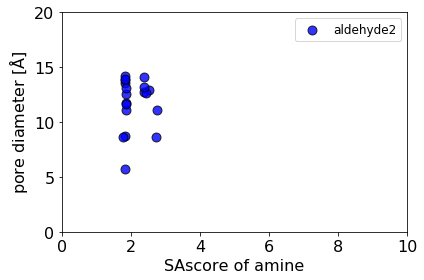

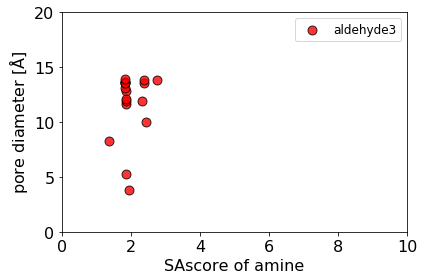

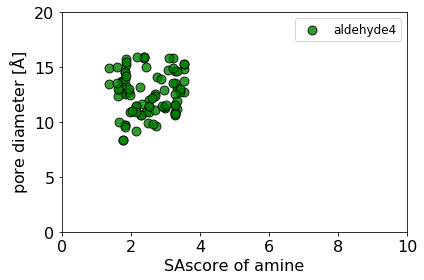

In [369]:
for i in ald_colo:
    fig, ax = plt.subplots()
    data = final_2_db[final_2_db.bb1 == i]
    ax.scatter(data.SA2, data.p_diam_opt, c=ald_colo[i], alpha=0.8, 
               edgecolor='k', marker='o', s=80, label=i)
    ax.tick_params(axis='both', which='major', labelsize=16)
#     ax.set_xlabel('synthetic accessibility of amine', fontsize=16)
    ax.set_xlabel('SAscore of amine', fontsize=16)
    ax.set_ylabel('pore diameter [$\mathrm{\AA}$]', fontsize=16)
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 20)

    ax.legend(fontsize=12)
    fig.tight_layout()
    fig.savefig(output_dir+"pdiam_VS_SA2_3f_"+i+".pdf",
                dpi=720, bbox_inches='tight')

99    aldehyde1_amine3f_234_4p4
Name: name, dtype: object
311    aldehyde2_amine3f_264_4p4
Name: name, dtype: object
535    aldehyde3_amine3f_8_4p4
Name: name, dtype: object
541    aldehyde4_amine3f_236_4p4
587    aldehyde4_amine3f_226_4p4
605    aldehyde4_amine3f_153_4p4
623     aldehyde4_amine3f_23_4p4
629    aldehyde4_amine3f_228_4p4
639    aldehyde4_amine3f_234_4p4
717     aldehyde4_amine3f_35_4p4
Name: name, dtype: object


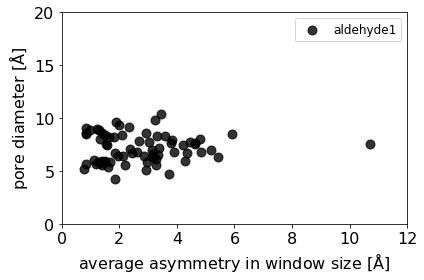

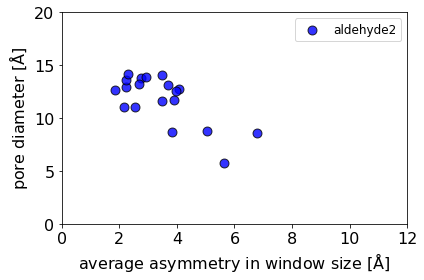

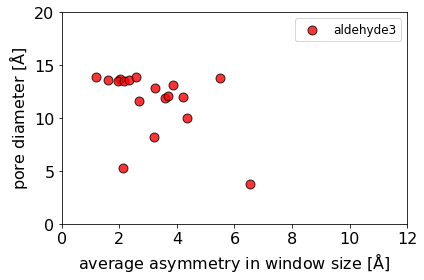

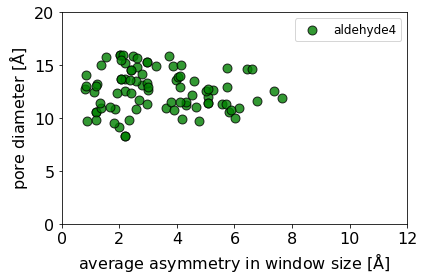

In [356]:
for i in ald_colo:
    fig, ax = plt.subplots()
    data = final_2_db[final_2_db.bb1 == i]
    ax.scatter(data.assym/data.w_no, data.p_diam_opt, c=ald_colo[i], alpha=0.8, 
               edgecolor='k', marker='o', s=80, label=i)
    print(data[data.assym/data.w_no > 6]['name'])
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.set_xlabel('average asymmetry in window size [$\mathrm{\AA}$]', fontsize=16)
    ax.set_ylabel('pore diameter [$\mathrm{\AA}$]', fontsize=16)
    ax.set_xlim(0, 12)
    ax.set_ylim(0, 20)

    ax.legend(fontsize=12)
    fig.tight_layout()
    fig.savefig(output_dir+"pdiam_VS_asym_3f_"+i+".pdf",
                dpi=720, bbox_inches='tight')

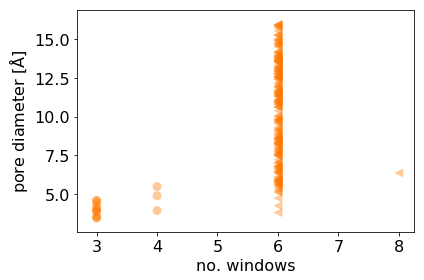

In [357]:
fig, ax = plt.subplots()
for i, row in final_db.iterrows():
#     if row.bb1 == 'aldehyde1':
    ax.scatter(row.w_no, row.p_diam_opt, c='#FF7900', alpha=0.4, edgecolor='none', marker=topo_markers[row.topo], s=80)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_xlabel('no. windows', fontsize=16)
ax.set_ylabel('pore diameter [$\mathrm{\AA}$]', fontsize=16)
# ax.set_xlim(-0.5, 13)
# ax.set_ylim(-5, 120)
fig.tight_layout()
fig.savefig(output_dir+"pdiam_VS_wn_3f.pdf",
            dpi=720, bbox_inches='tight')

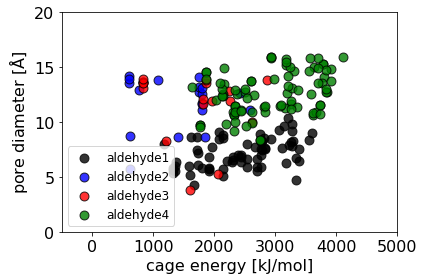

In [358]:
fig, ax = plt.subplots()
for i in ald_colo:
    data = final_2_db[final_2_db.bb1 == i]
    ax.scatter(data.cage_ey, data.p_diam_opt, c=ald_colo[i], alpha=0.8, 
               edgecolor='k', marker='o', s=80, label=i)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_xlabel('cage energy [kJ/mol]', fontsize=16)
ax.set_ylabel('pore diameter [$\mathrm{\AA}$]', fontsize=16)
ax.set_xlim(-500, 5000)
ax.set_ylim(0, 20)

ax.legend(fontsize=12)
fig.tight_layout()
fig.savefig(output_dir+"pdiam_VS_cageE_3f.pdf",
            dpi=720, bbox_inches='tight')

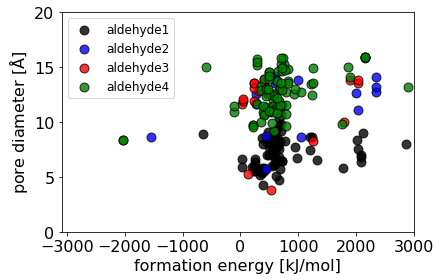

In [359]:
fig, ax = plt.subplots()
for i in ald_colo:
    data = final_2_db[final_2_db.bb1 == i]
    ax.scatter(data.form_ey, data.p_diam_opt, c=ald_colo[i], alpha=0.8, 
               edgecolor='k', marker='o', s=80, label=i)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_xlabel('formation energy [kJ/mol]', fontsize=16)
ax.set_ylabel('pore diameter [$\mathrm{\AA}$]', fontsize=16)
ax.set_xlim(-3090, 3000)
ax.set_ylim(0, 20)

ax.legend(fontsize=12)
fig.tight_layout()
fig.savefig(output_dir+"pdiam_VS_formE_3f.pdf",
            dpi=720, bbox_inches='tight')

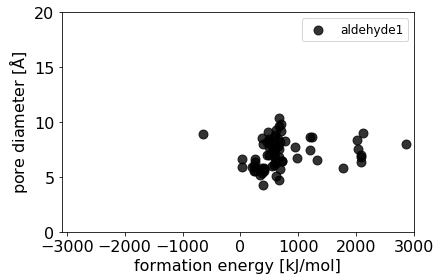

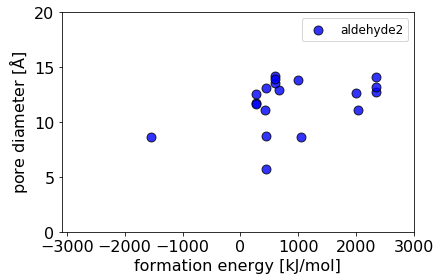

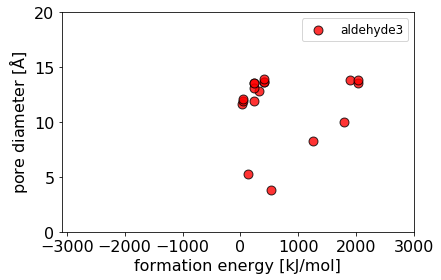

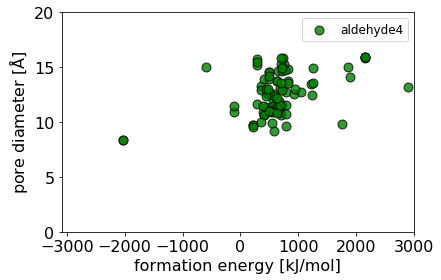

In [360]:
for i in ald_colo:
    fig, ax = plt.subplots()
    data = final_2_db[final_2_db.bb1 == i]
    ax.scatter(data.form_ey, data.p_diam_opt, c=ald_colo[i], alpha=0.8, 
               edgecolor='k', marker='o', s=80, label=i)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.set_xlabel('formation energy [kJ/mol]', fontsize=16)
    ax.set_ylabel('pore diameter [$\mathrm{\AA}$]', fontsize=16)
    ax.set_xlim(-3090, 3000)
    ax.set_ylim(0, 20)

    ax.legend(fontsize=12)
    fig.tight_layout()
    fig.savefig(output_dir+"pdiam_VS_formE_3f_"+i+".pdf",
                dpi=720, bbox_inches='tight')

#### Visulisation if you want

In [361]:
final_db.columns

Index(['name', 'bb1', 'SA1', 'bb2', 'SA2', 'topo', 'max_diam', 'p_diam',
       'p_vol', 'p_diam_opt', 'p_vol_opt', 'w_no', 'w_max', 'w_min', 'w_avg',
       'w_diff', 'collapse', 'assym', 'bb1_ey', 'bb2_ey', 'cage_ey', 'form_ey',
       'rel_form_ey'],
      dtype='object')

In [273]:
for i, row in final_2_db.iterrows():
    if row.p_diam_opt < 10:
        continue
    if abs(row.form_ey) < 1000:
        continue
    print(row.bb1, row.bb2, row.topo, row.form_ey, row.bb2_ey, row.p_diam_opt, row.rel_form_ey)
    view(read(output_dir+row.bb1+'_'+row.bb2+'_'+row.topo+'_opt_PWout.xyz'))
    input()

aldehyde2 amine3f_103 4p4 2335.663 -173.5306 12.750981234626654 1952.2215

aldehyde2 amine3f_206 4p4 2004.4801000000002 73.715 12.62146901759912 1670.3777000000002

aldehyde2 amine3f_207 4p4 2038.9005 107.6227 11.090893879472256 1676.3537999999999

aldehyde2 amine3f_146 4p4 2335.6634 -173.5307 14.115262927655207 1952.2217999999998


KeyboardInterrupt: 

In [372]:
for a in ald_colo:
    smiles_done = []
    data = final_2_db[final_2_db.bb1 == a]
    counts = 0
    max_c = 9
    sorted_data = data.sort_values(by=['SA2'])
    sorted_mols = []
    sorted_props = []
    for i, row in sorted_data.iterrows():
        NAME = amines3f+row.bb2+'.mol'
        smiles = Chem.MolToSmiles(Chem.MolFromMolFile(NAME))
        if smiles not in smiles_done:
            smiles_done.append(smiles)
            sorted_mols.append(Chem.MolFromSmiles(smiles))
            sorted_props.append((row.SA2, row.p_diam_opt))
    ranges = np.arange(0, len(sorted_mols)+1, max_c)
    print(ranges)
    for i in ranges:
        if i > max_c:
            break
        print(a, i)
        _set = sorted_mols[i: i+max_c]
        _set_props = sorted_props[i: i+max_c]
        if len(_set) == 0:
            break
        img = Draw.MolsToGridImage(_set, molsPerRow=3, subImgSize=(125, 125), 
                                   # legends=[str(round(i[0], 3))+' ('+str(round(i[1], 2))+')' 
                                   legends=[str(round(i[1], 2))
                                            for i in _set_props],
                                   useSVG=False)
        img.save(output_dir+'candidate_amines2f_'+a+'_'+str(i)+'.png')

#     break

[ 0  9 18 27 36]
aldehyde1 0
aldehyde1 9
[0 9]
aldehyde2 0
aldehyde2 9
[0]
aldehyde3 0
[ 0  9 18 27 36 45]
aldehyde4 0
aldehyde4 9


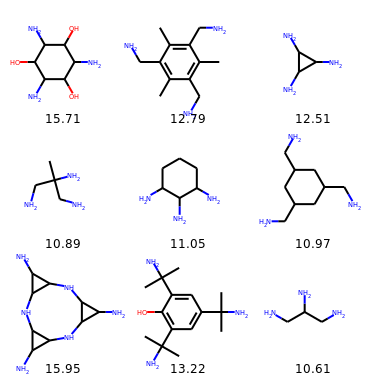

In [373]:
img

In [378]:
full_dataset[full_dataset.bb2 == 'amine3f_43']

,name,bb1,SA1,bb2,SA2,topo,max_diam,p_diam,p_vol,p_diam_opt,p_vol_opt,w_no,w_max,w_min,w_avg,w_diff,collapse,assym
106,aldehyde1_amine3f_43_1p1,aldehyde1,-,amine3f_43,-,1p1,14.380993,0.017612,0.000003,0.045363,0.000049,1,1.150708,1.150708,1.150708,None,0,0.000000
107,aldehyde1_amine3f_43_4p4,aldehyde1,-,amine3f_43,-,4p4,26.080583,8.257383,294.798982,8.443283,315.161097,6,6.405253,4.595952,5.634600,0.7875681960130207,0,12.597865
286,aldehyde2_amine3f_43_1p1,aldehyde2,-,amine3f_43,-,1p1,15.302038,1.389720,1.405336,1.715763,2.644663,3,2.151760,2.010182,2.057479,0.044461233420585465,0,0.283155
287,aldehyde2_amine3f_43_4p4,aldehyde2,-,amine3f_43,-,4p4,27.581038,5.282433,77.179245,6.801311,164.731427,4,8.249411,2.389860,5.393679,None,0,20.067237
466,aldehyde3_amine3f_43_1p1,aldehyde3,-,amine3f_43,-,1p1,16.766283,1.389902,1.405890,2.561029,8.795127,3,2.562717,2.181808,2.407335,0.9638713323716382,0,0.761817
467,aldehyde3_amine3f_43_4p4,aldehyde3,-,amine3f_43,-,4p4,31.462318,1.681396,2.488907,3.315254,19.078720,-1,-1.000000,-1.000000,-1.000000,-1,2,-1.000000
646,aldehyde4_amine3f_43_1p1,aldehyde4,-,amine3f_43,-,1p1,19.288446,1.149095,0.794450,3.059653,14.997375,3,4.138049,3.267090,3.816587,0.12408453054027113,0,1.741917
647,aldehyde4_amine3f_43_4p4,aldehyde4,-,amine3f_43,-,4p4,32.635249,12.733906,1081.143953,12.786981,1094.719053,6,8.796483,8.095573,8.379784,0.3821120342391861,0,4.775415


In [379]:
for a in ald_colo:
    if a != 'aldehyde3':
        continue
    data = final_db[final_db.bb1 == a]
    sorted_data = data.sort_values(by=['SA2'])
    for i, row in sorted_data.iterrows():
        print(row.bb1, row.bb2, row.topo, row.form_ey, row.bb2_ey, row.p_diam_opt, row.rel_form_ey)
#         view(read(output_dir+row.bb1+'_'+row.bb2+'_'+row.topo+'_opt_PWout.xyz'))
#         input()
    break

aldehyde3 amine3f_143 4p4 1252.4872 -142.8427 8.234866832025782 1069.1822
aldehyde3 amine3f_40 4p4 406.6002 -26.6105 13.892618454102207 458.3434
aldehyde3 amine3f_16 4p4 406.6002 -26.6105 13.66798342529126 458.3434
aldehyde3 amine3f_5 4p4 229.75059999999996 17.6019 13.582044089592435 325.70619999999997
aldehyde3 amine3f_48 4p4 229.75059999999996 17.6019 13.140110764565911 325.70619999999997
aldehyde3 amine3f_51 4p4 229.75059999999996 17.6019 13.54530551923685 325.70619999999997
aldehyde3 amine3f_13 4p4 406.6002 -26.6105 13.650105092162779 458.3434
aldehyde3 amine3f_101 4p4 28.508799999999837 313.7573 11.613211617340644 149.13159999999988
aldehyde3 amine3f_80 4p4 129.53510000000006 351.8302 5.274115701145481 288.2308000000001
aldehyde3 amine3f_44 4p4 42.05639999999971 310.3704 12.12382931653759 159.29229999999978
aldehyde3 amine3f_9 4p4 35.816899999999805 351.8302 11.927761423109068 194.51259999999985
aldehyde3 amine3f_123 4p4 326.49789999999985 346.9388 12.818152462310676 465.451699999